In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 27 Lecture 2 Assignment

In this assignment, we will learn about interpreting linear models. We will use the google play store dataset loaded below and analyze the regression from this dataset.

In [10]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [11]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

We will predict app ratings using other features describing the app. Recall from the previous assignment our data cleansing steps and do the following:

1. Remove the following columns: app, category, size, installs, genres, last updated, current ver, android ver
2. Convert all columns to numeric and remove rows where this conversion causes null values

In [12]:
reviews = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv"
)

drop_cols = [
    "App",
    "Category",
    "Size",
    "Installs",
    "Genres",
    "Last Updated",
    "Current Ver",
    "Android Ver",
]

reviews = reviews.drop(columns=drop_cols)
reviews = reviews.dropna()

# Remove dollar signs and convert price to numeric
reviews["Price"] = reviews["Price"].str.strip("$")
reviews["Price"] = pd.to_numeric(reviews["Price"])

# Dropping high price apps (out of scope of projects interest in typical app behavior)
reviews = reviews[reviews["Price"] < 20]

# Convert reviews to numeric
reviews["Reviews"] = pd.to_numeric(reviews["Reviews"])

# Convet Type to bool
reviews["is_free"] = reviews["Type"] == "Free"
reviews["is_free"] = reviews["is_free"].astype(int)
reviews = reviews.drop(columns="Type")

# Convert content rating to numeric
reviews = reviews[~reviews["Content Rating"].isin(["Adults only 18+", "Unrated"])]
content_rating_map = {"Everyone": 0, "Everyone 10+": 1, "Teen": 2, "Mature 17+": 3}
reviews["Content Rating"] = reviews["Content Rating"].replace(content_rating_map)


print(reviews.shape)
reviews.head(2)

(9330, 5)


,Rating,Reviews,Price,Content Rating,is_free
0,4.1,159,0.0,0,1
1,3.9,967,0.0,0,1


<IPython.core.display.Javascript object>

3. Split the data into test and train subsets with 20% of the data in the test set

In [13]:
X = reviews.drop(columns="Rating")
y = reviews["Rating"]

<IPython.core.display.Javascript object>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

<IPython.core.display.Javascript object>

4. Normalize the data with QuantileTransformer. Many of the features are highly skewed.

In [15]:
transformer = QuantileTransformer()
transformer.fit(X_train)

X_train_scl = transformer.transform(X_train)
X_test_scl = transformer.transform(X_test)

X_train = pd.DataFrame(X_train_scl, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scl, index=X_test.index, columns=X_test.columns)

<IPython.core.display.Javascript object>

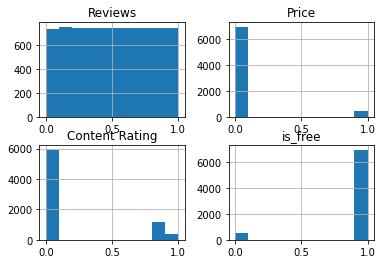

<IPython.core.display.Javascript object>

In [16]:
X_train.hist()
plt.show()

Checking for multicollinearity

In [17]:
print_vif(X_train)

VIF results
-------------------------------
const             38821.868433
Reviews               1.067352
Price              2395.450222
Content Rating        1.033974
is_free            2395.900628
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [20]:
X_train = X_train.drop(columns="is_free")
X_test = X_test.drop(columns="is_free")

<IPython.core.display.Javascript object>

In [21]:
print_vif(X_train)

VIF results
-------------------------------
const             4.389587
Reviews           1.066798
Price             1.034247
Content Rating    1.033752
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Create a linear regression model using statsmodels. Look at the coefficient values and their associated p values. Additionally, check model assumptions of homoscedacity, normality of errors, and multicollinearity.

In [23]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     145.5
Date:                Tue, 01 Sep 2020   Prob (F-statistic):           1.24e-91
Time:                        09:26:51   Log-Likelihood:                -5434.9
No. Observations:                7464   AIC:                         1.088e+04
Df Residuals:                    7460   BIC:                         1.091e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.9752      0.012    326.980      0.000       3.951       3.999
Reviews            0.4235      0.021     20.404      0.000       0.383       0.464
Price              0.1941      0.025      7.902      0.000       0.146       0.242
Content Rating    -0.0378      0.016     -2.350      0.019      -0.069      -0.006
==============================================================================
Omnibus:                     2279.892   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10362.053
Skew:                          -1.421   Prob(JB):                         0.00
Kurtosis:                       8.024   Cond. No.                         5.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

Checking homoscedasticity

In [27]:
# null hypothesis: homoscedastic residuals
# null hypothesis: heteroscedastic residuals
_, p, _, _ = het_breuschpagan(model.resid, X_train_const)
p

# We fail homoscedastic assumption

4.627260250547687e-169

<IPython.core.display.Javascript object>

Checking normality

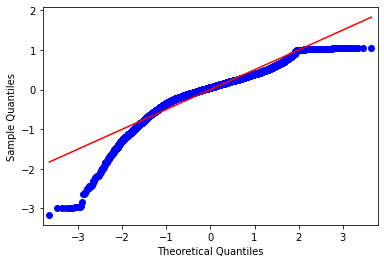

<IPython.core.display.Javascript object>

In [28]:
sm.qqplot(model.resid, line="s")
plt.show()

# We fail normality assumption

Using the information above, try to select only the variables you think will lead to a better model and construct that model. Print out a summary

In [ ]:
# Before the model was built, the is_free column (original `Type`) was dropped to
# alleviate multicollinearity.

Plot the scatterplots between the independent variables you select and ratings. Do you think given these graphs, these variables have good predictive power? 

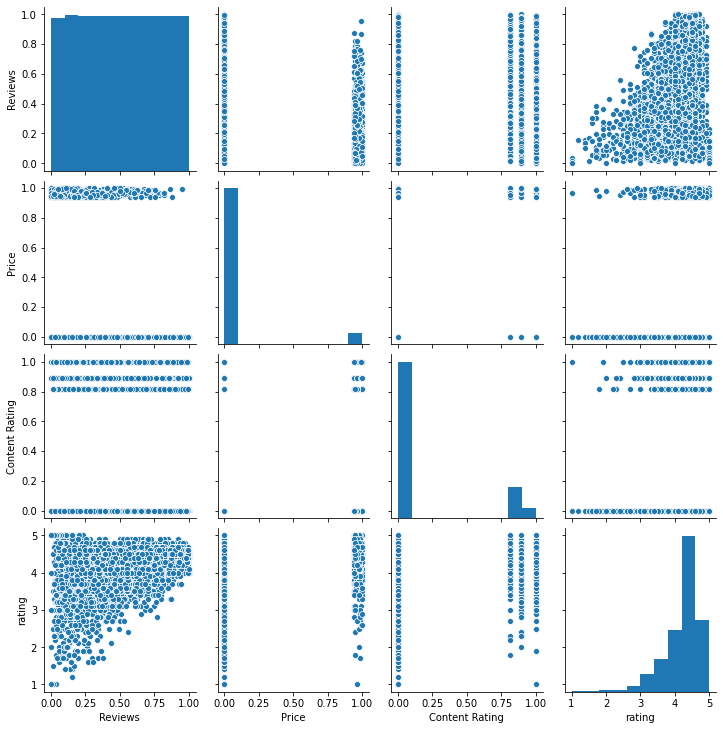

<IPython.core.display.Javascript object>

In [29]:
# No bright shining predictors, we see some relationship
# with the number of reviews, but this doesnt seem to be the
# most predictive relationship (i.e. we can see that the minimum
# rating increases as the number of reviews increase, but there
# is much variability - the max rating stays the same)
plot_df = X_train.copy()
plot_df["rating"] = y_train

sns.pairplot(plot_df)
plt.show()

What data processing could you do to improve this model? Experiment.

In [ ]:
# Nah